In [1]:
import json, requests, os, time, scipy
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader

#from dGbyG.Chemistry.Compound import Compound
#from dGbyG.Chemistry.Reaction import Reaction
from dGbyG.utils.constants import *
from dGbyG.utils.ChemFunc import *
from dGbyG.config import *
from dGbyG.network.Dataset import Train_Dataset
from dGbyG.network.GNNetwork import MP_network
from dGbyG.train.trainer import Model
from dGbyG.api.inference import Compound, Reaction

In [2]:
s = '*C(=O)N([H])[C@]([H])(C(=O)N(*)[H])C([H])([H])O[H]'
mol = to_mol('C00002', cid_type='kegg')

In [3]:
m = Compound(mol)

In [4]:
m.standard_dGf_prime

array([-2295.881], dtype=float32)

In [5]:
m.condition['pH'] = 8.0

In [6]:
m.transformed_standard_dGf_prime

array([-2224.8052], dtype=float32)

In [7]:
m.condition

{'T': 298.15, 'pH': 8.0, 'I': 0.25, 'pMg': 14.0, 'e_potential': 0.0}

In [8]:
default_condition

{'T': 298.15, 'pH': 7.0, 'I': 0.25, 'pMg': 14.0, 'e_potential': 0.0}

In [ ]:
mm = m.mol
atom = mm.GetAtomWithIdx(4)
print(atom.GetSymbol())
atom.SetFormalCharge(0)
atom.GetNumExplicitHs()
atom.GetNumImplicitHs()
atom.SetNumExplicitHs(0)
Chem.SanitizeMol(mm)

In [2]:
r = {'[H+]': -1.0, '[Fe+2]': -1.0}
#r = 'C01644 = C00001'

In [3]:
R = Reaction(r, rxn_type='dict')

In [4]:
R.rxnSmiles

{'[H+]': -1.0, '[Fe+2]': -1.0}

In [5]:
R.is_balanced()

False

In [18]:
R.balance()

In [19]:
R.equationSmiles

'[H]OC([H])([H])[C@@]([H])(O[H])C(=O)[C@]([H])(O[H])[C@]([H])(O[H])C([H])([H])OP(=O)(O[H])O[H] = [H]OC([H])([H])C1(O[H])O[C@]([H])(C([H])([H])OP(=O)(O[H])O[H])[C@@]([H])(O[H])[C@]1([H])O[H]'

In [13]:
R.is_balanced(ignore_H2O=False)

True

In [12]:
R.can_be_transformed

False

In [13]:
R.transform(condition1=default_condition, condition2=default_condition)

In [14]:
a = parse_equation(r)

In [15]:
for x in zip(a.items(),[0,9,8]):
    print(x)

(('[H]OC([H])([H])[C@@]([H])(O[H])C(=O)[C@]([H])(O[H])[C@]([H])(O[H])C([H])([H])OP(=O)(O[H])O[H]', -1), 0)
(('[H]OC([H])([H])C1(O[H])O[C@]([H])(C([H])([H])OP(=O)(O[H])O[H])[C@@]([H])(O[H])[C@]1([H])O[H]', 1), 9)


In [16]:
d = pd.read_csv(kegg_additions_csv_path, index_col=0)

In [17]:
m0 = Compound(to_mol('[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]', cid_type='smiles'))

In [18]:
m0 = m0.mol

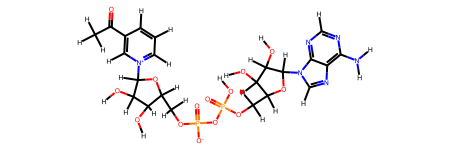

In [19]:
m0

In [20]:
Compound(m0).Smiles

'[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]'

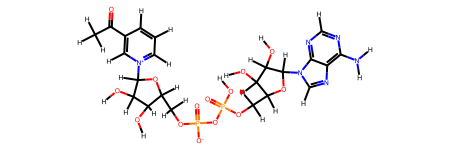

In [21]:
normalize_mol(m0)

In [22]:
rdMolStandardize.StandardizeSmiles('[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]')

'CC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'

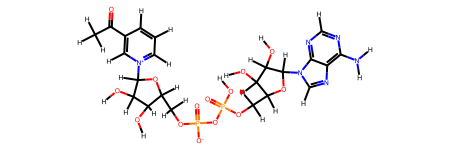

In [23]:
m0

In [24]:
Compound(m0).Smiles

'[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]'

In [25]:
u = rdMolStandardize.Uncharger()
m00 = u.uncharge(m0)

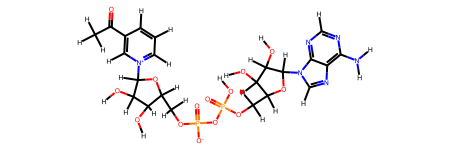

In [26]:
Chem.AddHs(m00)

In [27]:
Compound(Chem.AddHs(m00)).Smiles

'[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]'

In [28]:
Chem.MolToSmiles(m0, allHsExplicit=True)

'[H][O][C]1([H])[C]([H])([n]2[c]([H])[n][c]3[c]([N]([H])[H])[n][c]([H])[n][c]32)[O][C]([H])([C]([H])([H])[O][P](=[O])([O][H])[O][P](=[O])([O-])[O][C]([H])([H])[C]2([H])[O][C]([H])([n+]3[c]([H])[c]([H])[c]([H])[c]([C](=[O])[C]([H])([H])[H])[c]3[H])[C]([H])([O][H])[C]2([H])[O][H])[C]1([H])[O][H]'

In [29]:
Chem.MolToSmiles(m0)

'[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]'

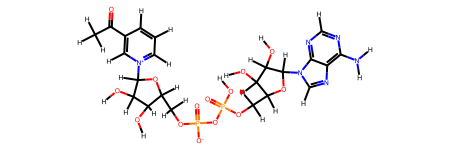

In [30]:
rdMolStandardize.Normalize(m0, )

In [31]:
a = rdMolStandardize.ChargeParent(m0)

In [32]:
Chem.MolToSmiles(a)

'CC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'

In [33]:
Chem.MolToSmiles(m0)

'[H]OC1([H])C([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)OC([H])(C([H])([H])OP(=O)(O[H])OP(=O)([O-])OC([H])([H])C2([H])OC([H])([n+]3c([H])c([H])c([H])c(C(=O)C([H])([H])[H])c3[H])C([H])(O[H])C2([H])O[H])C1([H])O[H]'

In [13]:
a = os.popen(f"cxcalc pKa -t acidic,basic -a 8 -b 8 test.smi")
with open('test.tsv', 'w') as f:
    f.write(a.read())


[H+]	8			"pka: Inconsistent molecular structure."
[H][#8]P(=O)([#8][H])[#8]C([H])([H])[C@]([H])([#7]([H])-[#6](-*)=O)[#6](=O)-[#7]([H])-*	67			"pka: Calculation result is not defined for query molecules: [#8]P([#8])(=O)[#8]-[#6]-[#6@H](-[#7]-[#6](-*)=O)-[#6](=O)-[#7]-*"
[H][#8][C@]([H])(C([H])([H])[H])C([H])([H])[#6](=O)-[#16]-*	87			"pka: Calculation result is not defined for query molecules: [#6]-[#6@@H](-[#8])-[#6]-[#6](=O)-[#16]-*"
[H][#8][C@@]1([H])[C@@]([H])([#8][H])[C@@]([H])([#8]P(=O)([#8][H])[#8]C([H])([H])[C@]([H])([#8]-[#6](-*)=O)C([H])([H])[#8]-[#6](-*)=O)[C@]([H])([#8][H])[C@@]([H])([#8][H])[C@]1([H])[#8]P(=O)([#8][H])[#8][H]	109			"pka: Calculation result is not defined for query molecules: [#8]-[#6@H]-1-[#6@@H](-[#8])-[#6@@H](-[#8]P([#8])(=O)[#8]-[#6]-[#6@@H](-[#6]-[#8]-[#6](-*)=O)-[#8]-[#6](-*)=O)-[#6@H](-[#8])-[#6@@H](-[#8])-[#6@@H]-1-[#8]P([#8])([#8])=O"
[H][#8]C([H])([H])[C@]([H])([#7]([H])-[#6](-*)=O)[#6](=O)-[#7]([H])-*	226			"pka: Calculation result is not defined

In [14]:
s = [x.strip() for x in open('test.smi', 'r').readlines()]

In [15]:
p = pd.read_csv('test.tsv', sep='\t').drop(columns='id')
p.index = s
p = p.reset_index()
p = p.rename(columns={'index':'smiles'})

In [16]:
op = pd.read_csv(chemaxon_pka_csv_path)
p = pd.concat([op,p])

In [17]:
p = p.drop_duplicates()

In [18]:
p.to_csv(chemaxon_pka_csv_path, index=False)

In [23]:
m = to_mol('C00033', cid_type='kegg')
#m = to_mol('[Fe]', cid_type='smiles')

In [24]:
m = Compound(m)

In [30]:
Reaction(m.Smiles).rxnSmiles

{'[H]OC(=O)C([H])([H])[H]': 1}

In [26]:
m.ddGf()

14.042742763091155

In [27]:
get_pKa(m, source='file')

{'acidicValuesByAtom': [{'atomIndex': 2, 'value': 4.54}],
 'basicValuesByAtom': []}